<img src="logo_UNSAM.jpg" align="right" width="120">


# <center>Trabajo final: Análisis y procesamiento de señales: *Detección de crisis epilépticas mediante análisis de EEG*</center> 

### <center> - Alumna: Lola Pampin</center> 

### <center> - Profesor: Mariano Llamedo Soria</center> 

### <center>Febrero 2026</center> 

## <center> Universidad Nacional de San Martín, Escuela de Ciencia y Tecnología</center> 




# **I. Introducción**
## *Marco clinico*
### Electrocargiograma
El electrocardiograma (ECG) es un estudio que mide las señales eléctricas del corazón durante cada latido. Su análisis permite identificar patologías, alteraciones del ritmo cardíaco y variaciones en la conducción eléctrica. Los principales componentes de un latido son:
- *Onda P*: representa la despolarización auricular (las cavidades superiores del corazón se activan eléctricamente). Es de baja amplitud (0.1-0.2 mV) y relativamente lenta.
- *Complejo QRS*: corresponde a la despolarización ventricular (activación eléctrica de los ventrículos, las cavidades encargadas de bombear sangre al cuerpo). Es el componente de mayor energía y rapidez en el ECG. Su pendiente pronunciada requiere preservar componentes de frecuencia relativamente altas.
- *Onda T*: asociada a la repolarización ventricular (luego de activarse, las células vuelven a su voltaje "de reposo"). Es más ancha que la onda P y su contenido espectral es de menor frecuencia que el QRS.
### **Epilepsia** 
La epilepsia es un trastorno neurológico crónico caracterizado por la aparición recurrente de crisis, producto de una actividad neuronal anormal, excesiva o sincrónica en el cerebro. Estas crisis pueden generar consecuencias negativas tanto a corto como a largo plazo, incluyendo caídas, traumatismos, mortalidad prematura, trastornos psiquiátricos, déficits cognitivos y dificultades en el ámbito social, laboral y académico.
 
 ***Clasificación de epilepsia***
 
La epilepsia se puede clasificar según el tipo de convulsión. Según la Liga Internacional contra la Epilepsia las convulsiones se clasifican según donde se originan en el cerebro. A partir de este parámetro las convulsiones pueden ser:
- Generalizadas: se originan simultáneamente en ambos hemisferios (inicio generalizado).
- Parciales: son aquellas que poseen un inicio focal, es decir en una sola zona del cerebro. Este tipo de convulsión se divide a su vez en simples (afectan una pequeña porción del cerebro)  o complejas (comienzan en un área y se propagan a otra). 
La principal diferencia entre una convulsión parcial simple y una convulsión parcial compleja es la alteración de la consciencia y un período postictal en esta última, que también se presenta en una convulsión generalizada. Es decir, las convulsiones parciales complejas y las generalizadas pueden presentarse de forma similar, pero difieren en que en las parciales la convulsión se propaga de un área focal a otra (no se presenta en ambos hemisferios al mismo tiempo).






# **II. Métodos**



# **III. Desarrollo**

In [30]:
# %% LIBRERIAS
import matplotlib.pyplot as plt
from os import listdir
from scipy import signal as sig
from scipy.signal import welch, windows, butter, filtfilt, find_peaks
import pandas as pd
import scipy.io as sio
import wave
from numpy.fft import fft
from scipy.interpolate import interp1d
import numpy as np

# %% Variables globales
FS=200 #Hz
F1=5
F2=15
FS_hr = 4.0  # Hz frecuencia para muestreo uniforme para aplicacion de la FFT
## Frecuencia cardiaca minima y maxima (umbral fisiologico) ##
MIN_HR=30 #latidos/min
MAX_HR=220
RR_MIN = 0.3 #[s]  (200 bpm)
rr_max = 2#[s]  (30 bpm)

####Tiempos de episodios segun pacientes
sz01 = ("00:14:36", "00:16:12")
sz02_01 = ("01:02:43", "01:03:43")
sz02_02 = ("02:55:51", "02:56:16")  
sz03_01 = ("01:24:34", "01:26:22")
sz03_02 = ("02:34:27", "02:36:17")  
sz04 = ("00:20:10", "00:21:55")
sz05 = ("00:24:07", "00:25:30")
sz06_01 = ("00:51:25", "00:52:19")
sz06_02 = ("02:04:45", "02:06:10") 
sz07 = ("01:08:02", "01:09:31")


In [31]:
# %% Lectura  + Graficos ECG sin filtrar

def leer_archivo(path, start, stop):
    #Lectura de archivos
    start *= 12000
    stop *= 12000
    raw = np.fromfile('data/' + path, dtype=np.int16)
    gain = 25
    baseline = 26

    ecg_mV = (raw - baseline) / gain
    t = np.arange(len(ecg_mV)) / FS
    
    return ecg_mV[start:stop],t[start:stop]
def graficar_archivo(ecg_mV, t, name):
    #Graficos ECG
    
    plt.figure(figsize=(12, 4))
    plt.plot(t, ecg_mV, linewidth=1)
    #plt.xlim([0, 10])
    plt.xlim (1200,1250)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Voltage [mV]")
    plt.title(f"ECG ({name})")
    plt.grid(True)
    plt.show()
    
    return

In [32]:
def detect_rpeaks(ecg,t):
    # Filtrado para QRS
    b, a = butter(2, [F1, F2], btype='band', fs=FS)
    xf = filtfilt(b, a, ecg) #filtrado bidereccional

    # Altura mínima relativa y distancia mínima entre picos
    # Distancia mínima según HR máxima permitida
    min_dist = int(FS * 60.0 / MAX_HR) #distancia que tendrian los latidos si hr=220 lat/min
    # Altura mínima: percentil relativo
    med = np.median(xf)
    mad = np.median(np.abs(xf - med))
    k=4
    h = med + k * 1.4826 * mad   # k típico: 3–6
    peaks, _ = find_peaks(xf, distance=min_dist, height=h)
    # Filtrar picos demasiado cercanos según HR fisiológico
    rr = np.diff(peaks) / FS
    rr_ok = (rr > 60.0/MAX_HR) & (rr < 60.0/MIN_HR)
    keep = np.insert(rr_ok, 0, True)
    peaks = peaks[keep]
    prueba_latidos(ecg,t, peaks)

    return peaks
    
def prueba_latidos(ecg,t, peaks):
    #Funcion para comprobar la deteccion de latidos graficamente
    
    plt.figure(figsize=(12,4))
    plt.plot(t, ecg, label='ECG')
    plt.xlim (1200,1250)
    plt.plot(t[peaks], ecg[peaks], 'r x', label='R-peaks')
    plt.legend(); plt.xlabel('Tiempo (s)'); plt.ylabel('mV')
    plt.title('Detección de picos R')
    plt.show()
    
    return

In [33]:
def const_RR (latidos, estado):
    
    idx_r = np.asarray(latidos, dtype=float) #Convert the input to an array
    t_r = latidos / FS  # tiempos de ocurrencia de cada latido (s)

    #armo mi intervalo RR en segundos
    # np.diff : out[i] = a[i+1] - a[i] 
    rr = np.diff(t_r)   # [s] 
    good = (rr >= RR_MIN) & (rr <= rr_max) #Elimino valores absurdos

    rr_clean = rr[good]
    t = t_r[1:][good]   # tiempos asociados al RR

    plt.figure(figsize=(10,4))
    plt.plot(t, rr_clean, '-o', markersize=3)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('RR (s)')
    plt.title('Serie de intervalos RR')
    plt.grid(True)
    plt.show()
    
    hr = 60/rr_clean # array de ritmo cardiaco [latidos/min]
    

#### INTERPOLACION
    
    t0 = t[0]
    t1 = t[-1]
    t_u = np.arange(t0, t1, 1.0/FS_hr)   # eje de tiempo uniforme --> COMO ESTABLEZCO FS_HR ?????
    
    # Interpolación lineal (suele ser suficiente para HRV lenta)
    f = interp1d(t, hr, kind='linear', fill_value='extrapolate', bounds_error=False)
    hr_u = f(t_u)   # HR(t) uniforme, en bpm
    
    # Ajuste polinomial de grado 4 (paper) sobre HR_u vs t_u
    p = np.polyfit(t_u, hr_u, deg=4)
    trend = np.polyval(p, t_u)
    
    hr_detr = hr_u - trend   # señal de HR sin tendencia (bpm)

    N = len(hr_detr)
    
    # Ventana rectangular (implícita); FFT de una sola cara
    HR = np.fft.rfft(hr_detr, n=N)
    freqs = np.fft.rfftfreq(N, d=1.0/FS_hr)
    
    # PSD no normalizada (proporcional); normalizar para comparar entre sujetos !!
    PSD = (np.abs(HR)**2) / N
    
    # Recorte de banda 0.01–0.10 Hz
    f_lo, f_hi = 0.01, 0.10
    band = (freqs >= f_lo) & (freqs <= f_hi)
    freq_band = freqs[band]
    psd_band  = PSD[band]
    
    # Pico espectral dentro de 0.01–0.10 Hz
    if np.any(band):
        kmax = np.argmax(psd_band)
        f_peak = freq_band[kmax]
        p_peak = psd_band[kmax]
    else:
        f_peak = np.nan
        p_peak = np.nan
    
    print(f"Pico en banda 0.01–0.10 Hz: {f_peak:.4f} Hz (potencia relativa={p_peak:.3g})")
    

    # HR(t) cruda vs detrendida
    plt.figure(figsize=(12,4))
    plt.plot(t_u, hr_u, label='HR interpolada (bpm)', alpha=0.6)
    plt.plot(t_u, hr_detr, label='HR sin tendencia [bpm]', color='r')
    plt.plot(t_u, trend, label='Tendencia polinomial grado 4', color='k', lw=2)
    plt.xlabel('Tiempo [s]'); plt.ylabel('bpm'); plt.title('HR y tendencia')
    plt.legend(); plt.grid(True); plt.show()    
    
    plt.figure(figsize=(10,4)) 
    f = np.fft.rfftfreq(len(trend), d=1/FS)
    plt.plot(freqs, np.abs(HR))
    plt.xlim(0, 0.5)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude (|HR|)")
    plt.title(f'Amplitud FFT en función de la frecuencia ({estado.upper()})')


 
    return hr, t

In [34]:
# %% PSD POR WELCH
def welch_psd(ecg_uniform, name="ECG (uniforme)",
              seg_len_sec=60,        # 60–120 s va bien para 0.03–0.1 Hz
              overlap=0.5,           # 50% de solapamiento
              use_median=True,       # promedio robusto
              detrend_already_done=True):
    """
    Calcula PSD con Welch usando ventana de Hann PERIÓDICA (sym=False),
    adecuada para análisis espectral con FFT.
    
    ecg_uniform: señal ya remuestreada a fs (muestras uniformes)
    fs: frecuencia de muestreo [Hz]
    """

    x = np.asarray(ecg_uniform)
    n = len(x)
    if n < 4:
        raise ValueError("La señal es demasiado corta.")

    # --- nperseg desde segundos (clave para baja frecuencia) ---
    nperseg = int(seg_len_sec * FS)
    # Asegurar límites razonables
    nperseg = max(64, min(nperseg, n))  # al menos 64 muestras y no más que n
    
    # --- ventana Hann PERIÓDICA ---
    # sym=False -> versión periódica (mejor para FFT/Welch)
    win = windows.hann(nperseg, sym=False)

    # --- solapamiento ---
    noverlap = int(nperseg * overlap)
    
    # --- nfft (potencia de 2 >= nperseg, útil para eficiencia y resolución) ---
    def _next_pow2(x):
        return 1 << int(np.ceil(np.log2(max(1, int(x)))))
    nfft = max(nperseg, _next_pow2(nperseg))

    # --- detrend ---
    # Si ya detrendaste antes (p. ej. polinomio), evitá detrendarlo de nuevo aquí
    detrend_arg = False if detrend_already_done else 'constant'

    # --- promedio ---
    avg = 'median' if use_median else 'mean'

    # --- Welch ---
    f, Pxx = welch(x,
                   fs=FS,
                   window=win,
                   nperseg=nperseg,
                   noverlap=noverlap,
                   nfft=nfft,
                   detrend=detrend_arg,
                   return_onesided=True,
                   average=avg,
                   scaling='density')  # PSD en unidades/Hz

    # --- Gráfico ---
    eps = 1e-20
    plt.figure(figsize=(14, 6))
    plt.plot(f, 10*np.log10(Pxx + eps), 'x', label=f'PSD (Welch) - {name}')
    plt.title(f'PSD (Welch) - {name}')
    plt.ylabel('Densidad Espectral de Potencia [dB/Hz]')
    plt.xlabel('Frecuencia [Hz]')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.legend()
    plt.show()

    return f, Pxx

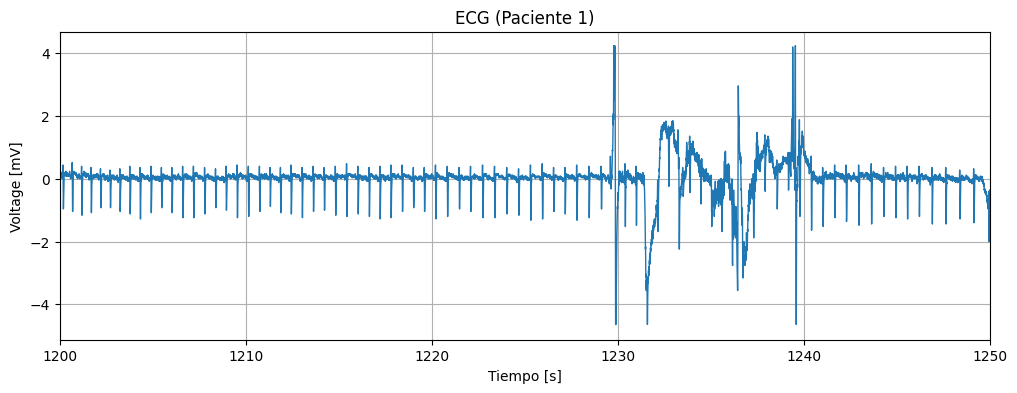

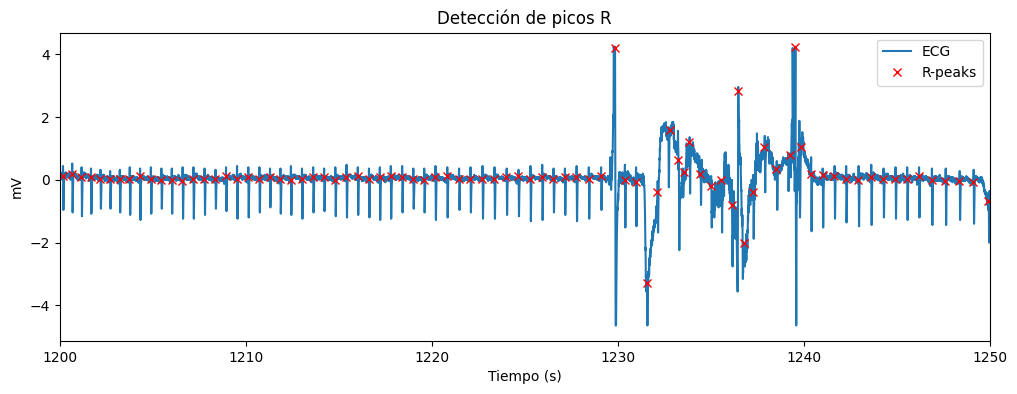

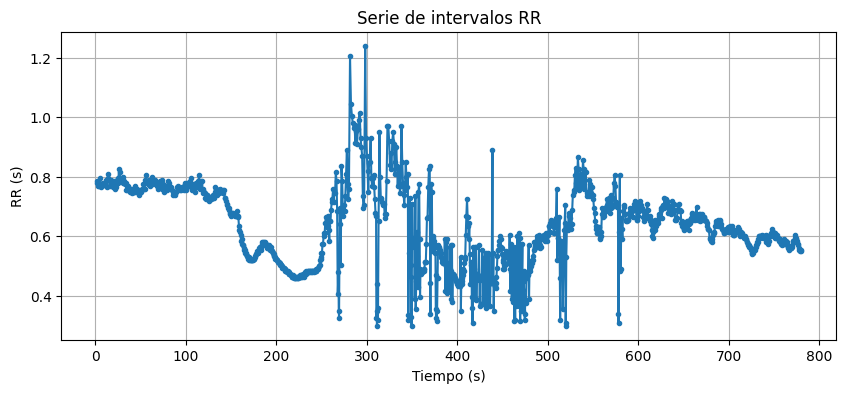

Pico en banda 0.01–0.10 Hz: 0.0244 Hz (potencia relativa=1.46e+04)


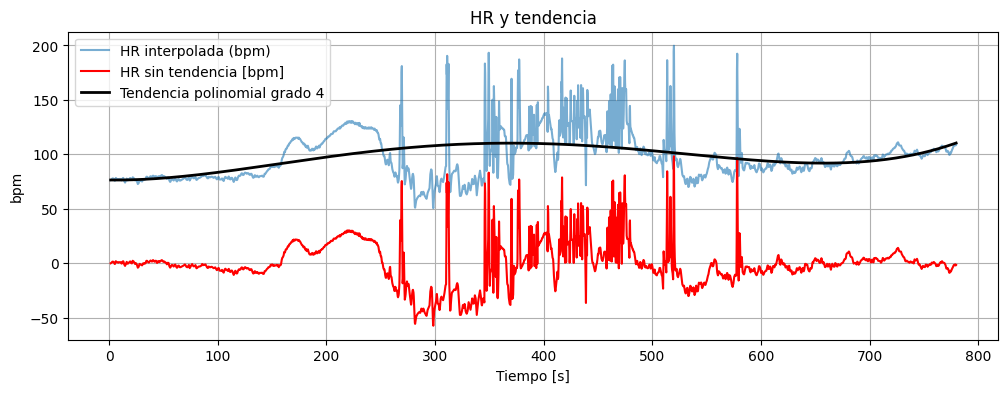

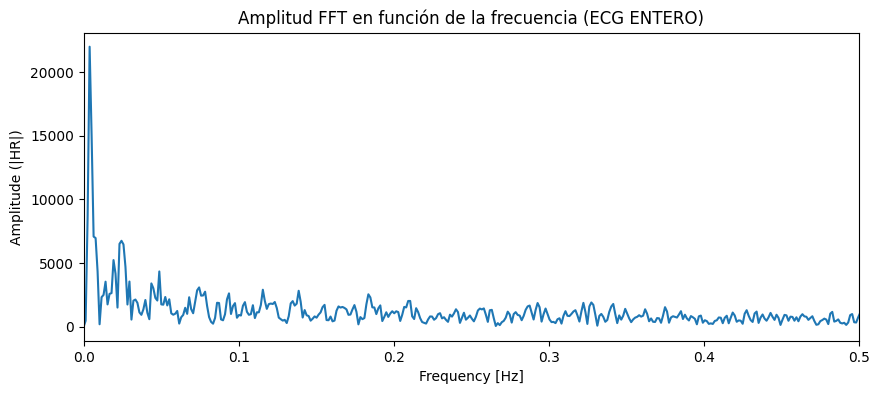

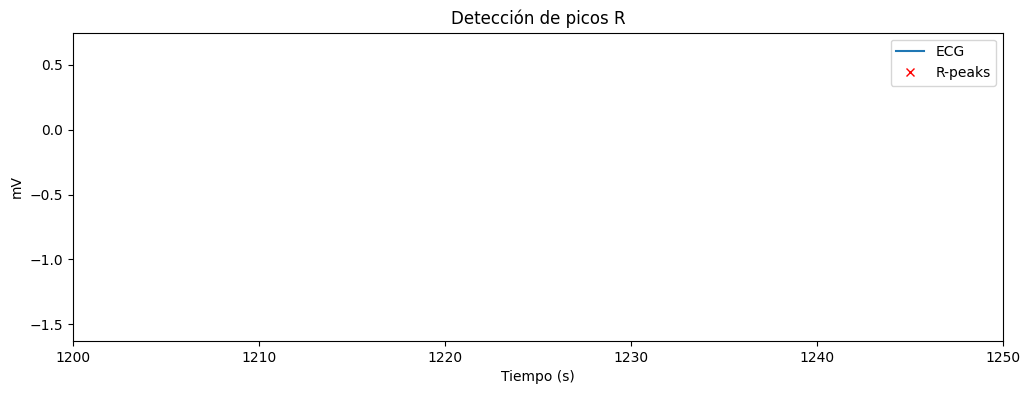

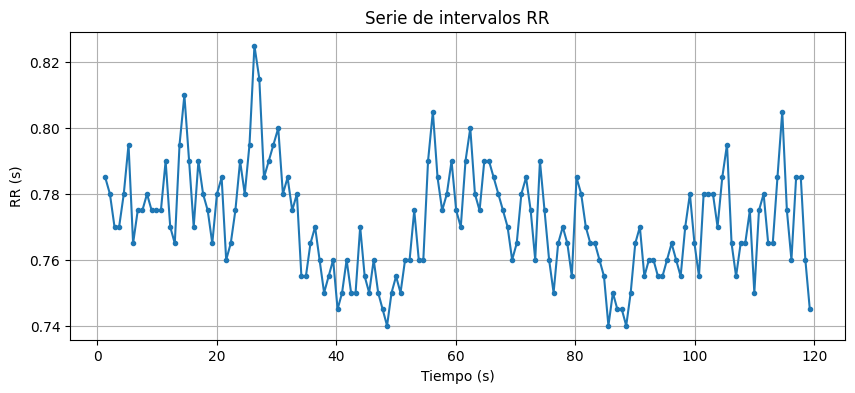

Pico en banda 0.01–0.10 Hz: 0.0254 Hz (potencia relativa=151)


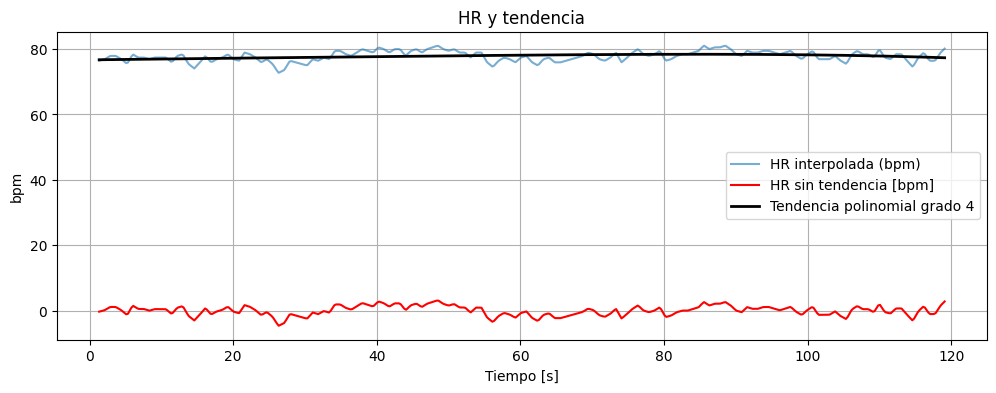

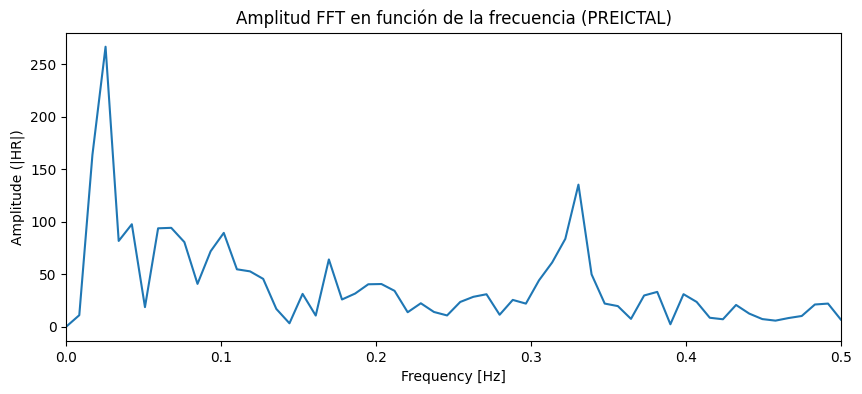

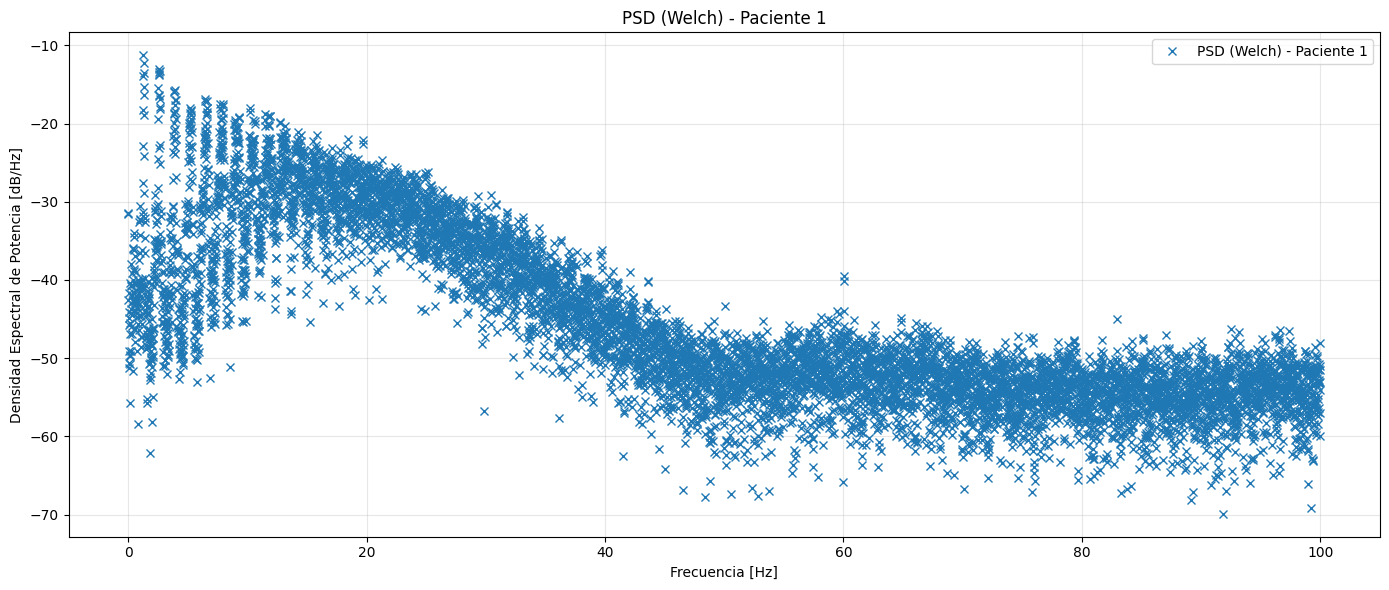

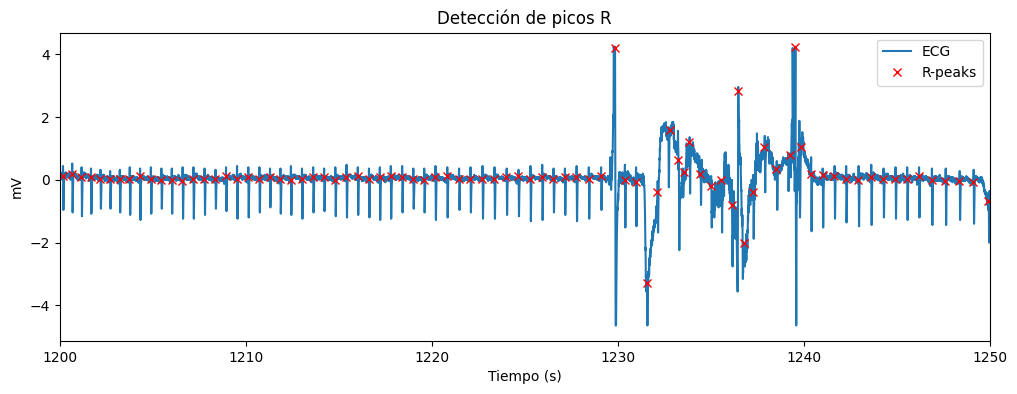

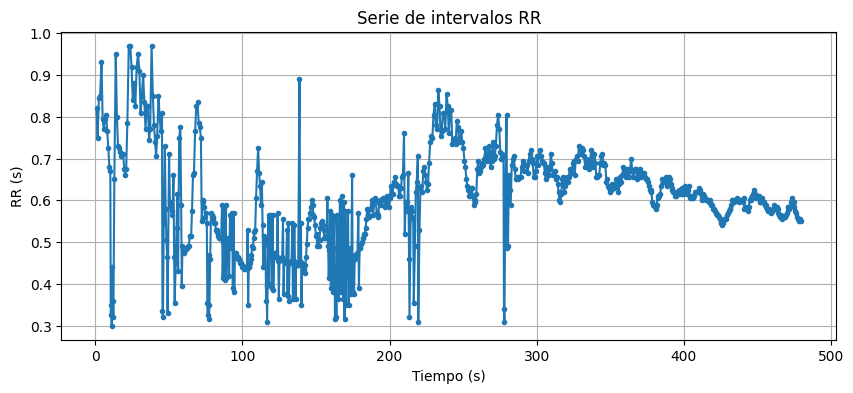

Pico en banda 0.01–0.10 Hz: 0.0251 Hz (potencia relativa=2.15e+04)


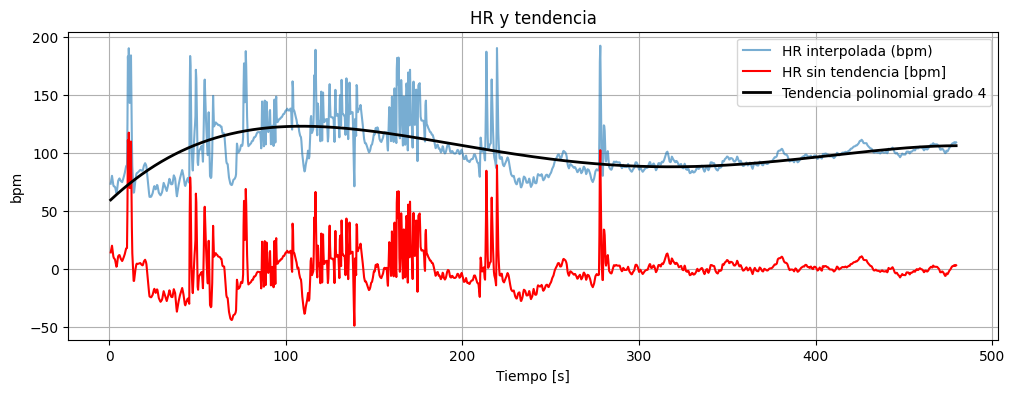

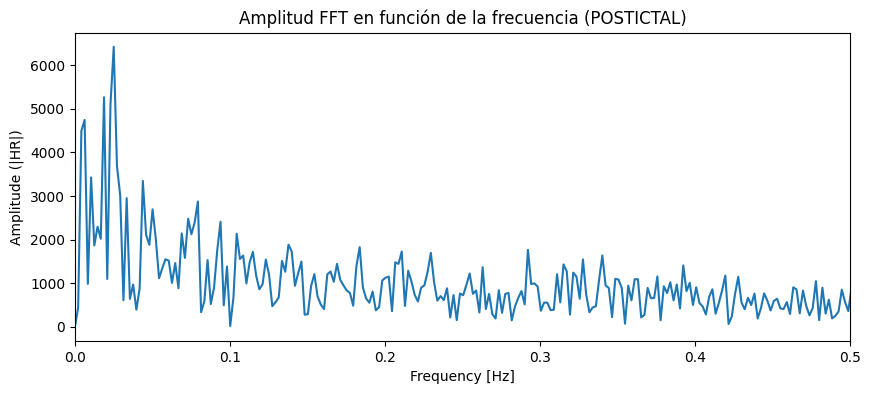

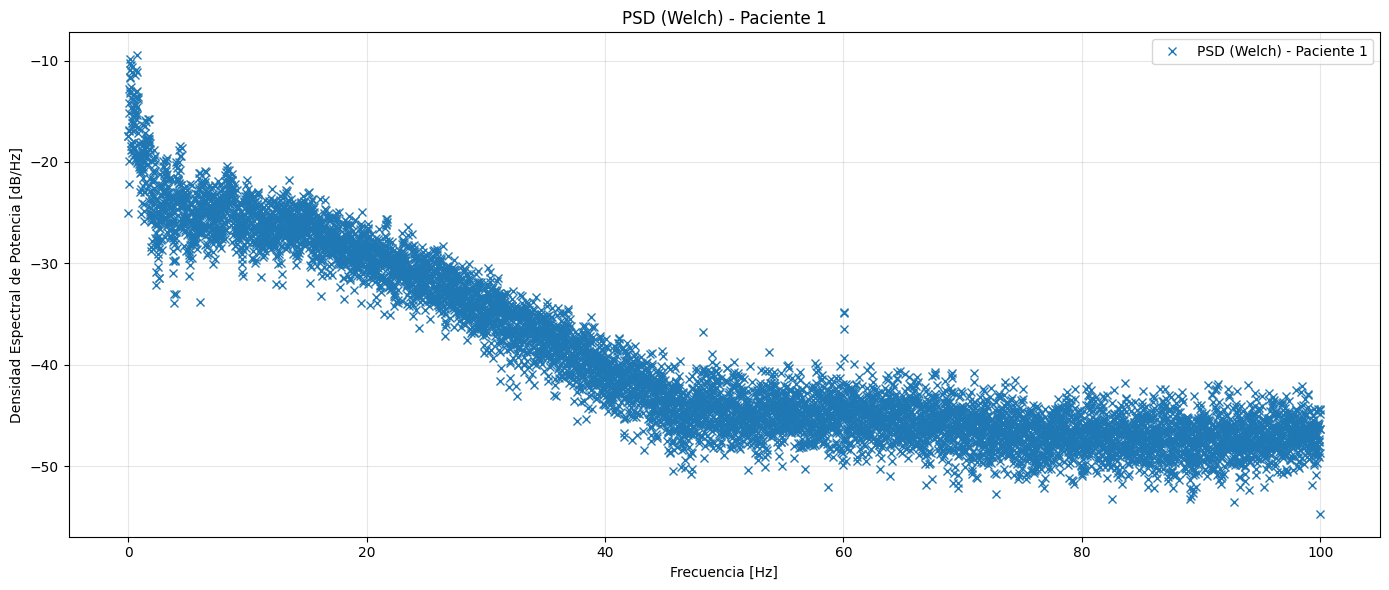

In [35]:
# %% main    

def main():
    files = [file for file in listdir('data')]
    paciente1 = files[0]
    ecg, t = leer_archivo(paciente1, 12 , 25)
    graficar_archivo(ecg, t, "Paciente 1")
    latidos= detect_rpeaks(ecg,t)
    hr, tr= const_RR(latidos, "ECG ENTERO")

    ecg_pre,t_pre= leer_archivo(paciente1, 12, 14)
    latidos= detect_rpeaks(ecg_pre,t_pre)
    hr_pre, tr_pre= const_RR(latidos, "PREICTAL")
    
    f_ecg_pre,pxx_pre= welch_psd(ecg_pre, "Paciente 1")
    
    ecg_post, t_post= leer_archivo(paciente1, 17, 25)
    latidos= detect_rpeaks(ecg_post,t_post)
    hr, tr= const_RR(latidos, "POSTICTAL")
    
    f_ecg_post,pxx_post= welch_psd(ecg_post, "Paciente 1")
    

if __name__=="__main__":
    main()

# **IV. Resultados**

# **V. Conclusiones**